# Matrix Multiplication -> Minibatch Training

## Load Dataset

In [ ]:
import os
import gzip
import numpy as np
from itertools import islice
import torch
from torch import tensor
from matplotlib import pyplot as plt
from fastcore.test import test_eq, test_close
from numba import njit
import pdb
from torch import nn
import torch.nn.functional as F

In [ ]:
def load_mnist(path, kind='train'):

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [ ]:
# labels from fashion mnist dataset
labels = ['T-shirt/top', 
          'Trouser',
          'Pullover',
          'Dress',
          'Coat',
          'Sandal',
          'Shirt',
          'Sneaker',
          'Bag',
          'Ankle boot'
         ]

In [ ]:
x_train, y_train = load_mnist('../../data/fashion_mnist', kind='train')
x_test, y_test = load_mnist('../../data/fashion_mnist', kind='t10k')

x_train, x_test = x_train.astype('float32') / 255., x_test.astype('float32') / 255.

In [ ]:
x_train.dtype, y_train.dtype

(dtype('float32'), dtype('uint8'))

In [ ]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60000, 784), (10000, 784), (60000,), (10000,))

## `chunk`

In [ ]:
lst = list(x_train[0])

In [ ]:
def chunks(array, bs):
    for i in range(0, len(array), bs):yield array[i: i + bs]

In [ ]:
vals = lst[300: 310]

In [ ]:
val_iter = iter(chunks(vals, 5))

In [ ]:
next(val_iter)

[0.8235294, 0.827451, 0.8352941, 0.8745098, 0.8627451]

<matplotlib.image.AxesImage>

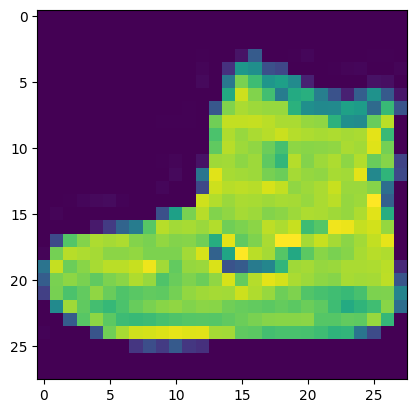

In [ ]:
plt.imshow(list(chunks(x_train[0], 28)))

In [ ]:
labels[y_train[0]] # What is the above image?

'Ankle boot'

## `islice` (replacement of `chunk`)

In [ ]:
vals_slice = islice(vals, 5)

In [ ]:
list(vals_slice)

[0.8235294, 0.827451, 0.8352941, 0.8745098, 0.8627451]

In [ ]:
lst_iter = iter(lst)
image = list(iter(lambda: list(islice(lst_iter, 28)), []))

<matplotlib.image.AxesImage>

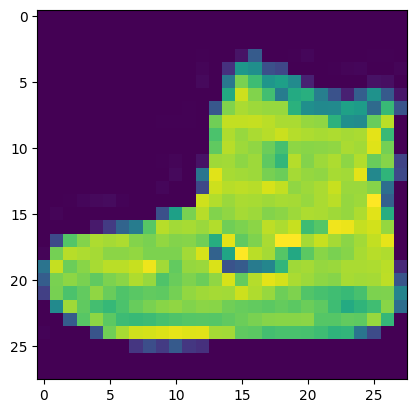

In [ ]:
plt.imshow(image)

## Tensor

In [ ]:
class Matrix:
    def __init__(self, xs):
        self.xs = xs
    def __getitem__(self, ids):
        return self.xs[ids[0]][ids[1]]

In [ ]:
m = Matrix(x_train)

In [ ]:
m[300, 301]

0.5254902

In [ ]:
a = tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]]); a[0, 1]

tensor(2)

## Matrix Multiplication: Brute Force

In [ ]:
x_train, x_test, y_train, y_test = map(tensor, (x_train, x_test, y_train, y_test))

In [ ]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    
    res = torch.zeros(ar, bc)
    
    for i in range(ar):
        for j in range(bc):
            for k in range(ac):
                res[i, j] += a[i, k] * b[k, j]
    return res

In [ ]:
xs = x_test[:5]
w = torch.randn(784, 10)
res = matmul(xs, w)

In [ ]:
test_close(res, torch.matmul(xs, w), eps=1e-4)

In [ ]:
%time _=matmul(xs, w)

CPU times: user 1.08 s, sys: 33.9 ms, total: 1.11 s
Wall time: 1.37 s


## Matrix Multiplication: Numba

In [ ]:
@njit
def dot(a, b):
    res = 0
    for i in range(len(a)):
        res += a[i] * b[i]
    return res

In [ ]:
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])

In [ ]:
dot(a, b)

32

In [ ]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    res = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            res[i, j] = dot(a[i], b[:, j])
    return res

In [ ]:
res = matmul(xs.numpy(), w.numpy())

In [ ]:
test_close(res, torch.matmul(xs, w), eps=1e-4)

In [ ]:
%time _=matmul(xs.numpy(), w.numpy())

CPU times: user 581 µs, sys: 29 µs, total: 610 µs
Wall time: 592 µs


## Matrix Multiplication: `einsum`

In [ ]:
res = torch.einsum('ik,kj->ikj', xs, w)

In [ ]:
res.shape

torch.Size([5, 784, 10])

In [ ]:
res.sum(1).shape

torch.Size([5, 10])

In [ ]:
test_close(res.sum(1), torch.matmul(xs, w), eps=1e-4)

In [ ]:
res = torch.einsum('ik,kj->ij', xs, w)
test_close(res, torch.matmul(xs, w), eps=1e-4)

In [ ]:
%time _=torch.einsum('ik,kj->ij', xs, w)

CPU times: user 611 µs, sys: 272 µs, total: 883 µs
Wall time: 560 µs


## Matrix Multiplication: Element wise operation

In [ ]:
a = torch.tensor([1, 2, 3])
b = torch.tensor([4, 5, 6])

In [ ]:
a * b

tensor([ 4, 10, 18])

In [ ]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    
    res = torch.zeros(ar, bc)
    
    for i in range(ar):
        for j in range(bc):
            res[i, j] = (a[i, :] * b[:, j]).sum()
    return res

In [ ]:
res = matmul(xs, w)

In [ ]:
test_close(res, torch.matmul(xs, w), eps=1e-4)

In [ ]:
%time _=matmul(xs, w)

CPU times: user 2.61 ms, sys: 1.73 ms, total: 4.35 ms
Wall time: 3.24 ms


## Matrix Multiplication: Broadcasting

In [ ]:
a = torch.tensor([10, -6, 4])

In [ ]:
a > 0 

tensor([ True, False,  True])

In [ ]:
a + 1

tensor([11, -5,  5])

In [ ]:
m = torch.tensor([[10, 20, 30], [40, 50, 60], [70, 80, 90]])

In [ ]:
c = torch.tensor([1, 2, 3])

In [ ]:
m.shape, c.shape

(torch.Size([3, 3]), torch.Size([3]))

In [ ]:
m + c

tensor([[11, 22, 33],
        [41, 52, 63],
        [71, 82, 93]])

In [ ]:
c + m

tensor([[11, 22, 33],
        [41, 52, 63],
        [71, 82, 93]])

In [ ]:
t = c.expand_as(m)

In [ ]:
t.storage()

 1
 2
 3
[torch.storage._TypedStorage(dtype=torch.int64, device=cpu) of size 3]

In [ ]:
t.stride(), t.shape

((0, 1), torch.Size([3, 3]))

In [ ]:
(xs[0][..., None] * w).sum(0).shape

torch.Size([10])

In [ ]:
def matmul(a, b):
    ar, ac = a.shape
    br, bc = b.shape
    
    res = torch.zeros(ar, bc)
    for i in range(ar):
        res[i] = (a[i, ..., None] * b).sum(0)
    return res

In [ ]:
res = matmul(xs, w)

In [ ]:
res.shape

torch.Size([5, 10])

In [ ]:
test_close(res, torch.matmul(xs, w))

In [ ]:
%time _=matmul(xs, w)

CPU times: user 1.57 ms, sys: 956 µs, total: 2.52 ms
Wall time: 4.39 ms


In [ ]:
%time _=xs@w

CPU times: user 107 µs, sys: 322 µs, total: 429 µs
Wall time: 3.19 ms


## Linear

In [ ]:
def lin(x, w, b): return x@w + b

In [ ]:
nh = 50
w1 = torch.randn(784, nh)
b1 = torch.zeros(nh)
w2 = torch.randn(nh, 1)
b2 = torch.zeros(1)

In [ ]:
lin(xs, w1, b1).shape

torch.Size([5, 50])

## Relu

In [ ]:
def relu(a): return a.clamp_min(0)

In [ ]:
z = torch.tensor([10, -6, 8]); relu(z)

tensor([10,  0,  8])

## Forward

In [ ]:
def forward(x):
    l1 = lin(x, w1, b1)
    l2 = relu(l1)
    return lin(l2, w2, b2)

In [ ]:
ys_pred = forward(xs); ys_pred.shape

torch.Size([5, 1])

## MSE

In [ ]:
ys_act = y_test[:5]; ys_act.shape

torch.Size([5])

In [ ]:
def mse(pred, act): return (pred[:, 0] - ys_act).pow(2).mean()

In [ ]:
mse(ys_pred, ys_act)

tensor(6151.3032)

## Forward & Backprop 

In [ ]:
def lin_grad(inp, out, w, b):
    inp.g =  out.g @ w.T
    w.g = inp.T @ out.g
    b.g = out.g.sum(0)

In [ ]:
def forward_backward(x, y):
    l1 = lin(x, w1, b1)
    l2 = relu(l1)
    out = lin(l2, w2, b2)
    loss = mse(out, y)
    
    out.g = 2 * (out[:, 0] - y).unsqueeze(-1) / x.shape[0]
    lin_grad(l2, out, w2, b2)
    l1.g = (l1 > 0).float() * l2.g
    lin_grad(x, l1, w1, b1)

In [ ]:
forward_backward(xs, ys_act)

In [ ]:
def chck_grad(w1, b1, w2, b2): 
    return list(map(lambda x: x.g.clone(), (w1, b1, w2, b2)))

In [ ]:
w1g, b1g, w2g, b2g = chck_grad(w1, b1, w2, b2)

In [ ]:
def make_grad(w1, b1, w2, b2): return list(map(lambda x: x.clone().requires_grad_(True), (w1, b1, w2, b2)))

In [ ]:
w11, b11, w22, b22 = make_grad(w1, b1, w2, b2)

In [ ]:
def forward(x, y):
    l1 = lin(x, w11, b11)
    l2 = relu(l1)
    out = lin(l2, w22, b22)
    return mse(out, y)

In [ ]:
loss = forward(xs, ys_act)

In [ ]:
loss.backward()

In [ ]:
for a, b in zip([w1g, b1g, w2g, b2g], [w11, b11, w22, b22]):
    test_close(a, b.grad, eps=1e-4)

## Layers as Classes

In [ ]:
class Linear:
    def __init__(self, w, b):
        self.w = w
        self.b = b
        
    def __call__(self, inp):
        self.inp = inp
        self.out = inp @ self.w + self.b
        return self.out
    
    def backward(self):
        self.inp.g = self.out.g @ self.w.T
        self.w.g = self.inp.T @ self.out.g
        self.b.g = self.out.g.sum(0)

In [ ]:
class Relu:
    def __call__(self, inp):
        self.inp = inp
        self.out = self.inp.clamp_min(0.)
        return self.out

    def backward(self):
        self.inp.g = (self.inp > 0).float() * self.out.g

In [ ]:
class MSE:
    def __call__(self, pred, act):
        self.inp = pred
        self.diff = (pred[:, 0] - act)
        self.out =  self.diff.pow(2).mean()
        return self.out
    
    def backward(self):
        
        self.inp.g = 2 * self.diff.unsqueeze(-1) / self.inp.shape[0]

In [ ]:
class Model:
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Linear(w1, b1), Relu(), Linear(w2, b2)]
        self.loss = MSE()
        
    def __call__(self, x, y):
        for layer in self.layers:
            x = layer(x)
        return self.loss(x, y)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers):
            l.backward()

In [ ]:
m = Model(w1, b1, w2, b2)

In [ ]:
loss = m(xs, ys_act)

In [ ]:
loss

tensor(6151.3032)

In [ ]:
m.backward()

In [ ]:
test_close(m.layers[0].w.g, w1.g)
test_close(m.layers[0].b.g, b1.g)
test_close(m.layers[2].w.g, w2.g)
test_close(m.layers[2].b.g, b2.g)

## Create `Module`

In [ ]:
class Module:
    def __call__(self, *args):
        print('hi')
        self.args = args
        self.out = self.forward(*self.args)
        return self.out
    def forward(self): raise Exception('Not implemented')
    def bwd(self): raise Exception('Not implemented')
    def backward(self): self.bwd(self.out, *self.args)

In [ ]:
class Linear(Module):
    def __init__(self, w, b):
        self.w = w
        self.b = b
        
    def forward(self, inp):
        return inp@self.w + self.b
    
    def bwd(self, out, inp):
        inp.g = out.g @ self.w.T
        self.w.g = inp.T @ out.g
        self.b.g = out.g.sum(0)

In [ ]:
class Relu(Module):
    def forward(self, inp):
        return inp.clamp_min(0.)
    def bwd(self, out, inp):
        inp.g = (inp > 0) * out.g

In [ ]:
class Mse(Module):
    def forward(self, pred, act):
        print('calling mse')
        self.diff = (pred[:, 0] - act)
        return self.diff.pow(2).mean()
    def bwd(self, out, inp, act):
        inp.g = 2 * self.diff.unsqueeze(-1) / inp.shape[0]

In [ ]:
class Model(Module):
    def __init__(self, w1, b1, w2, b2):
        self.layers = [Linear(w1, b1), Relu(), Linear(w2, b2)]
        self.loss = Mse()
    def __call__(self, x, targ):
        for l in self.layers: x = l(x)
        return self.loss(x, targ)
    
    def backward(self):
        self.loss.backward()
        for l in reversed(self.layers): l.backward() 

In [ ]:
m = Model(w1, b1, w2, b2)

In [ ]:
m(xs, ys_act)

hi
hi
hi
hi
calling mse


tensor(6151.3032)

In [ ]:
m.backward()

In [ ]:
test_close(w1.g, w1g, eps=1e-4)
test_close(w2.g, w2g, eps=1e-4)
test_close(b1.g, b1g, eps=1e-4)
test_close(b2.g, b2g, eps=1e-4)

## Using Autograd

In [ ]:
class Linear(nn.Module):
    def __init__(self, w, b):
        super().__init__()
        self.w = w
        self.b = b
    def forward(self, x):
        return x@self.w + self.b

In [ ]:
class Relu(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        return x.clamp_min(0.)

In [ ]:
class Mse(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x, y):
        return (x[:, 0] - y).pow(2).mean()

In [ ]:
class Model(nn.Module):
    def __init__(self, w1, b1, w2, b2):
        super().__init__()
        self.layers = [Linear(w1, b1), Relu(), Linear(w2, b2)]
        self.loss = Mse()
    def forward(self, x, y):
        for l in self.layers: x = l(x)
        return self.loss(x, y)

In [ ]:
w11, b11, w22, b22 = make_grad(w1, b1, w2, b2)
m = Model(w11, b11, w22, b22)

In [ ]:
loss = m(xs, ys_act);loss

tensor(6151.3032, grad_fn=<MeanBackward0>)

In [ ]:
loss.backward()

In [ ]:
test_close(w11.grad, w1.g, eps=1e-4)

In [ ]:
test_close(b11.grad, b1.g, eps=1e-4)

In [ ]:
test_close(w22.grad, w2.g, eps=1e-4)

In [ ]:
test_close(b22.grad, b2.g, eps=1e-4)

## Log Cross Entropy

In [ ]:
nn.ReLU

torch.nn.modules.activation.ReLU

In [ ]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in, nh), nn.ReLU(), nn.Linear(nh, n_out)]
    def forward(self, x):
        for layer in self.layers: x = layer(x)
        return x

In [ ]:
m = Model(784, 50, 10)
out = m(xs)

In [ ]:
out.shape

torch.Size([5, 10])

In [ ]:
out

tensor([[-0.0445,  0.1940,  0.0292,  0.1249,  0.1164,  0.0496, -0.1825, -0.0041,
          0.0614,  0.0912],
        [ 0.0737,  0.4485, -0.2514,  0.2538,  0.1230,  0.1385, -0.3754, -0.0579,
          0.2001,  0.0246],
        [-0.0267,  0.1692, -0.0193, -0.0120,  0.0912,  0.1883, -0.2609, -0.0418,
          0.2150,  0.0883],
        [-0.0202,  0.1561, -0.0754,  0.1079,  0.0813,  0.1236, -0.2494, -0.0053,
          0.0730,  0.0779],
        [-0.0351,  0.2461, -0.1211,  0.1446,  0.0907,  0.1414, -0.2308, -0.0573,
          0.1844,  0.0430]], grad_fn=<AddmmBackward0>)

In [ ]:
def log_softmax(x):
    return x - x.exp().sum(-1, keepdim=True).log()

In [ ]:
log_softmax(out)

tensor([[-2.3954, -2.1569, -2.3218, -2.2260, -2.2346, -2.3013, -2.5335, -2.3550,
         -2.2896, -2.2597],
        [-2.3119, -1.9371, -2.6370, -2.1318, -2.2626, -2.2471, -2.7610, -2.4435,
         -2.1855, -2.3610],
        [-2.3772, -2.1814, -2.3699, -2.3625, -2.2594, -2.1622, -2.6114, -2.3923,
         -2.1355, -2.2622],
        [-2.3559, -2.1797, -2.4112, -2.2278, -2.2545, -2.2121, -2.5851, -2.3411,
         -2.2627, -2.2579],
        [-2.3881, -2.1070, -2.4741, -2.2085, -2.2623, -2.2116, -2.5838, -2.4103,
         -2.1687, -2.3101]], grad_fn=<SubBackward0>)

In [ ]:
test_close(log_softmax(out), F.log_softmax(out), eps=1e-4)

/var/folders/wh/7kgzwj895cb622q6m52_0v3r0000gn/T/ipykernel_29006/410582909.py:1: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  test_close(log_softmax(out), F.log_softmax(out), eps=1e-4)


In [ ]:
def logsumexp(x):
    a = torch.max(x, -1, keepdim=True).values
    return a.squeeze(-1) + (x-a).exp().sum(-1).log()

In [ ]:
test_close(logsumexp(out), torch.logsumexp(out, -1))

In [ ]:
def cross_entropy(x, y):
    return -F.log_softmax(x)[range(len(y)), y.long()].mean()

In [ ]:
cross_entropy(out, ys_act)

/var/folders/wh/7kgzwj895cb622q6m52_0v3r0000gn/T/ipykernel_29006/4108778016.py:2: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return -F.log_softmax(x)[range(len(y)), y.long()].mean()


tensor(2.3683, grad_fn=<NegBackward0>)

In [ ]:
test_close(cross_entropy(out, ys_act), F.cross_entropy(out, ys_act))

/var/folders/wh/7kgzwj895cb622q6m52_0v3r0000gn/T/ipykernel_29006/4108778016.py:2: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return -F.log_softmax(x)[range(len(y)), y.long()].mean()


## Train loop

In [ ]:
def accuracy(logits, y):
    return (logits.argmax(-1) == y).float().mean()

In [ ]:
m = Model(784, 50, 10)

In [ ]:
def train(epoch, bs=32, lr=0.05):
    for i in range(epoch):
        for j in range(len(x_train)):
            s = slice(j, j + bs)
            xb, yb = x_train[s], y_train[s]
            
            logits = m(xb)
            loss = F.cross_entropy(logits, yb)
            loss.backward()
            if j == 0: print('loss ', loss.item(), 'accuracy ', accuracy(logits, yb))

            with torch.no_grad():
                for layer in m.layers:
                    if hasattr(layer, 'weight'):
                        layer.weight -= lr * layer.weight.grad
                        layer.bias -= lr * layer.bias.grad
                        layer.weight.grad.zero_()
                        layer.bias.grad.zero_()

In [ ]:
train(3)

loss  2.273808240890503 accuracy  tensor(0.1562)
loss  0.7899407744407654 accuracy  tensor(0.8438)
loss  0.6727467775344849 accuracy  tensor(0.8750)


In [ ]:
accuracy(m(x_train), y_train), accuracy(m(x_test), y_test)

(tensor(0.8396), tensor(0.8206))

In [ ]:
F.cross_entropy(m(x_train), y_train), F.cross_entropy(m(x_test), y_test)

(tensor(0.7391, grad_fn=<NllLossBackward0>),
 tensor(0.9352, grad_fn=<NllLossBackward0>))